[![Roboflow Notebooks](https://ik.imagekit.io/roboflow/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Auto Train a Classification Model with Autodistill

Autodistill uses big, slower foundation models to train small, faster supervised models. Using `autodistill`, you can go from unlabeled images to inference on a custom model running at the edge with no human intervention in between.

![Autodistill Steps](https://media.roboflow.com/open-source/autodistill/steps.jpg)

As foundation models get better and better they will increasingly be able to augment or replace humans in the labeling process. We need tools for steering, utilizing, and comparing these models. Additionally, these foundation models are big, expensive, and often gated behind private APIs. For many production use-cases, we need models that can run cheaply and in realtime at the edge.

![Autodistill Connections](https://media.roboflow.com/open-source/autodistill/connections.jpg)

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Image dataset preperation
- Autolabel dataset
- Train target model
- Evaluate target model
- Upload dataset and model to Roboflow

Let's get started!


## Install Dependencies

In [1]:
!pip install autodistill autodistill-clip autodistill-yolov8 supervision roboflow -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.0/527.0 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.2/213.2 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.4 MB/s eta 0:00:00


## Import Dependencies

First, let's import the dependencies we will use in our project:

In [2]:
from autodistill_clip import CLIP
from autodistill.detection import CaptionOntology
from autodistill_yolov8 import YOLOv8
import supervision as sv
import roboflow
import cv2
import os

HOME = os.getcwd()

## Download Dataset

First, we need a dataset with which to work. Below, paste in a URL to any dataset on [Roboflow Universe](https://universe.roboflow.com). You will need a [free Roboflow account](https://app.roboflow.com) to download a dataset from Universe. Alternatively, you can upload your own dataset into this Colab notebook.

In [3]:
roboflow.login()

roboflow.download_dataset(dataset_url="https://universe.roboflow.com/jayke-boghean-2pxtg/damaged-signs-multi-label/dataset/3", model_format="multiclass")

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...

Extracting Dataset Version Zip to Damaged-Signs-Multi-label-3 in multiclass:: 100%|██████████| 1801/1801 [00:00<00:00, 2152.85it/s]


## Choose a Prompt

To label images with Autodistill, you need to set an Ontology.

An Ontology for classification consists of two parts:

1. A prompt that will be sent to the foundation model (in this example, CLIP), and;
2. A class name to which the prompt maps. This is the class name that will be saved in your dataset. The prompt and class name can be the same.

Below, we define an Ontology for two classes:

1. damaged sign
2. sign

We then run CLIP on an example image in the dataset.

Substitute the prompts and image name as appropriate in the code snippet below.

Feel free to experiment with the prompt until you get the expected result across different images in your dataset.

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 138MiB/s]


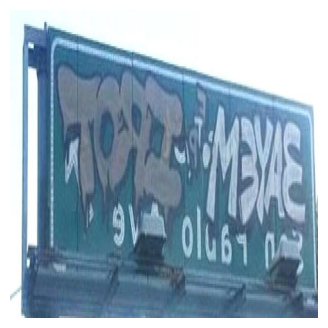

damaged sign


In [4]:
base_model = CLIP(ontology=CaptionOntology({"damaged sign": "damaged sign", "sign": "sign"}))

image = "./Damaged-Signs-Multi-label-3/train/0aad64567664f31b63fe4a5041fd9b89-graffiti-pictures-science_jpg.rf.9049d7164fbf942e158d503e2c607511.jpg"

pred = base_model.predict(image)

sv.plot_image(cv2.imread(image), size=(4, 4))

classes = base_model.ontology.classes()
print(classes[pred.class_id[0]])

## Label Dataset

Once you have a prompt that works well for your dataset, we can start labeling our dataset.

First, replace the folder name in the code cell below with a link to your `train` dataset. Then, run the code cell.

This will create a folder of labeled images called `dataset` on which we can train our model.

In [ ]:
base_model.label(input_folder="./Damaged-Signs-Multi-label-3/train", output_folder="./dataset")

## Train a Classification Model

Now we are ready to train a classification model. For this example, we will train an Ultralytics YOLOv8 classifiaction model. Run the code cell below to train a model using your dataset.

In [6]:
from autodistill_yolov8 import YOLOv8
target_model = YOLOv8("yolov8n-cls.pt")
target_model.train(f"{HOME}/dataset/", epochs=100)

100%|██████████| 5.28M/5.28M [00:00<00:00, 72.5MB/s]
New https://pypi.org/project/ultralytics/8.0.132 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/content/dataset/, epochs=100, patience=50, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augm

## Evaluate the Model

How does our model perform? Great question! To understand how our model performs, we can visualize the confusion matrix saved after the YOLOv8 training job completed.

In [11]:
from IPython.display import Image
import random

Image(filename=f'{HOME}/runs/classify/train/confusion_matrix.png', width=600)

random_image = random.choice(os.listdir(f"{HOME}/dataset/valid/damaged sign"))

results = target_model.predict(os.path.join(f"{HOME}/dataset/valid/damaged sign", random_image))

print(results[0].names)
print(results[0].probs)


image 1/1 /content/dataset/valid/damaged sign/IMG_8901_jpg.rf.954ac1fe0615b637515385d4a0afa138.jpg: 224x224 damaged sign 0.96, sign 0.04, 13.6ms
Speed: 0.6ms preprocess, 13.6ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


{0: 'damaged sign', 1: 'sign'}
tensor([0.9636, 0.0364], device='cuda:0')


## Upload Model to Roboflow

Optionally, you can upload your model to Roboflow. To do so:

1. Create a new project in Roboflow
2. Upload your data
3. Create a new dataset version
4. Run the code below

You will need to specify your [project ID and dataset version](https://docs.roboflow.com/rest-api#how-to-find-your-model-id-and-version) below.

In [ ]:
import roboflow

PROJECT_ID = ""
DATASET_VERSION = 1

roboflow.login()

rf = roboflow.Roboflow()

project = rf.workspace().project(PROJECT_ID)
project.version(DATASET_VERSION).deploy(model_type="yolov8-cls", model_path=f"./runs/classify/train/")

# 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.